In [67]:
%cd /mnt/d/steer/src

/mnt/d/steer/src


In [101]:
import torch
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

import lib.orientation as orient
from lib.camera import img_from_device, denormalize, FULL_FRAME_SIZE

from modules.pilotnet import PilotNet

In [70]:
model = PilotNet(num_past_frames=4, num_future_steps=30)
model.load_state_dict(torch.load("../pilotnet-v0.pt"))

/tmp/ipykernel_2759/531394638.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../pilotnet-v0.pt"))


<All keys matched successfully>

In [71]:
route_path = "../comma2k19/Chunk_1/processed/2018-08-02--08-34-47"
os.listdir(route_path)

['can_telemetry.npz', 'frame.npz', 'video']

In [73]:
frames = np.load(f"{route_path}/frame.npz")
frame_times, frame_positions, frame_orientations = frames[
    "t"], frames["position"], frames["orientation"]

print(len(os.listdir(f"{route_path}/video")))

1200


In [125]:
index = 510

ecef_from_local = orient.rot_from_quat(frame_orientations[index])
local_from_ecef = ecef_from_local.T
frame_positions_local = np.einsum(
    'ij,kj->ki', local_from_ecef, frame_positions - frame_positions[index])

frame_positions_local.shape

(1200, 3)

In [113]:
past_xyz = frame_positions_local[index-3:index+1]
print(past_xyz.shape)

(4, 3)


In [105]:
def draw_path(device_path, img, width=0.5, height=1, fill_color=(128, 0, 255), line_color=(0, 255, 0)):
    device_path_l = device_path + np.array([0, 0, height])
    device_path_r = device_path + np.array([0, 0, height])
    device_path_l[:, 1] -= width
    device_path_r[:, 1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(
        axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        # Scale image points from original image size to current size
        w1, h1 = FULL_FRAME_SIZE
        h2, w2, _ = img.shape
        u1, v1 = img_pts_l[i-1]
        u2, v2 = img_pts_r[i-1]
        u3, v3 = img_pts_l[i]
        u4, v4 = img_pts_r[i]
        pts = np.array([[u1, v1], [u2, v2], [u4, v4], [u3, v3]], np.float64)
        pts[:, 0] *= w2/w1
        pts[:, 1] *= h2/h1
        pts = pts.astype(np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], fill_color)
        cv2.polylines(img, [pts], True, line_color)

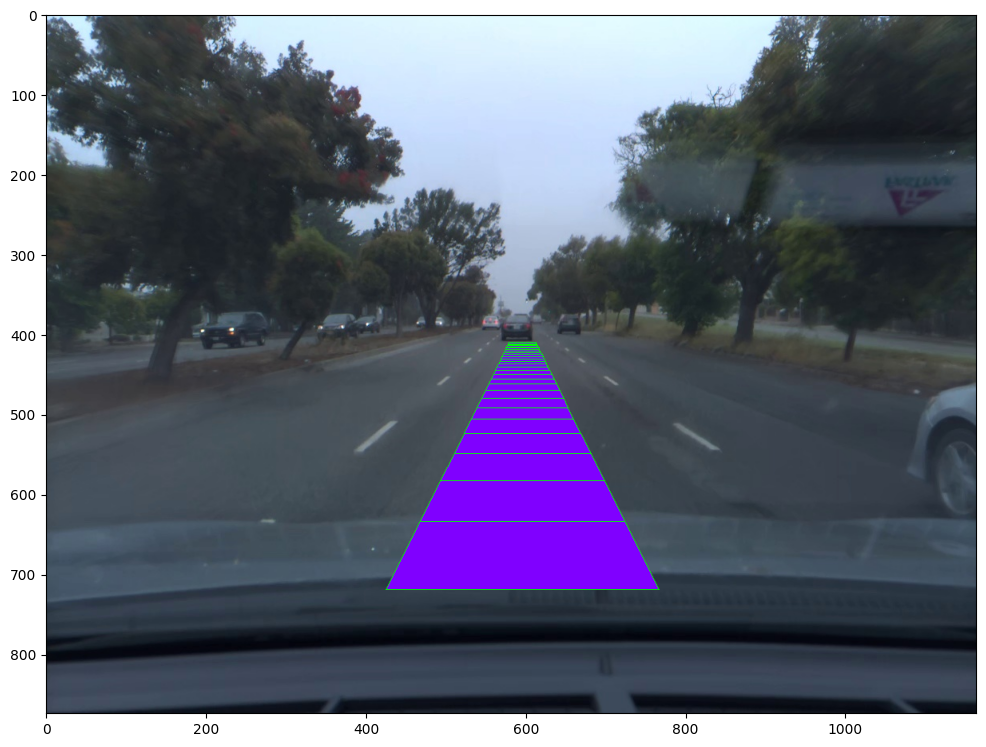

In [126]:
img = plt.imread(f'{route_path}/video/000510.jpeg')

draw_path(frame_positions_local[index+1:index+31], img)

plt.figure(figsize=(12, 12))
plt.imshow(img)